C:\Users\Quang Nguyen\AppData\Local\Temp\ipykernel_8836\2691377897.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_data[col].fillna(0, inplace=True)



Training model with weather for morning window...
morning Accuracy with weather: 0.9404
              precision    recall  f1-score   support

         low       0.98      0.98      0.98    526371
      medium       0.89      0.88      0.89    191948
        high       0.74      0.81      0.78     42328
   congested       0.83      0.67      0.74     11283

    accuracy                           0.94    771930
   macro avg       0.86      0.84      0.85    771930
weighted avg       0.94      0.94      0.94    771930



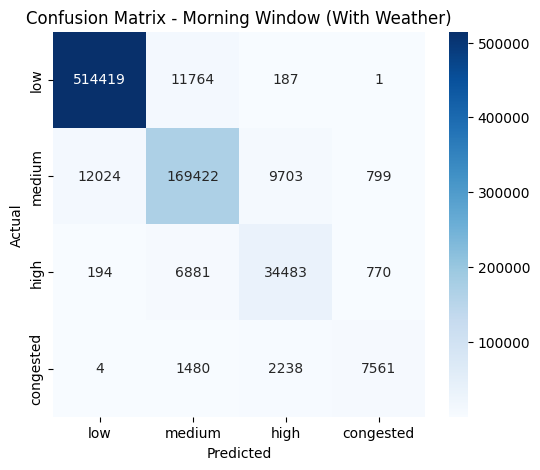


Training model with weather for noon window...
noon Accuracy with weather: 0.9628
              precision    recall  f1-score   support

         low       0.99      0.99      0.99    494907
      medium       0.94      0.94      0.94    228735
        high       0.82      0.83      0.82     41117
   congested       0.90      0.89      0.89      7171

    accuracy                           0.96    771930
   macro avg       0.91      0.91      0.91    771930
weighted avg       0.96      0.96      0.96    771930



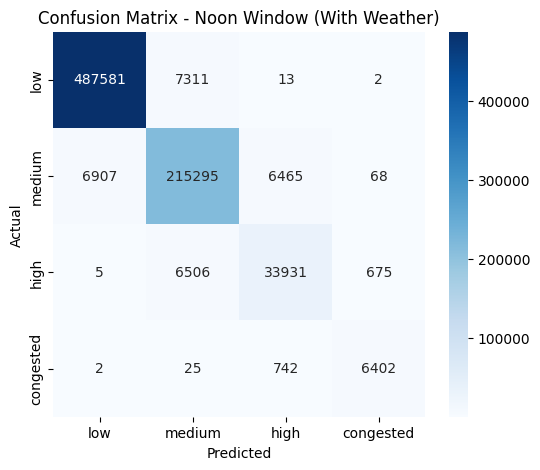


Training model with weather for afternoon window...
afternoon Accuracy with weather: 0.9496
              precision    recall  f1-score   support

         low       0.98      0.98      0.98    498061
      medium       0.90      0.94      0.92    217833
        high       0.85      0.70      0.77     44731
   congested       0.84      0.79      0.81     11305

    accuracy                           0.95    771930
   macro avg       0.89      0.85      0.87    771930
weighted avg       0.95      0.95      0.95    771930



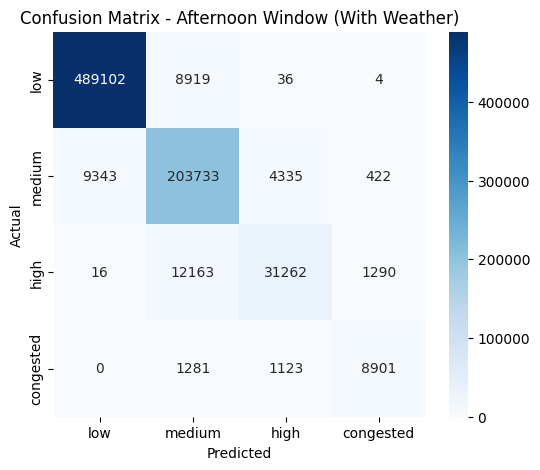


Training model with weather for night window...
night Accuracy with weather: 0.9612
              precision    recall  f1-score   support

         low       0.97      0.99      0.98    670001
      medium       0.89      0.79      0.84     94309
        high       0.70      0.76      0.73      6918
   congested       0.67      0.32      0.43       702

    accuracy                           0.96    771930
   macro avg       0.81      0.71      0.75    771930
weighted avg       0.96      0.96      0.96    771930



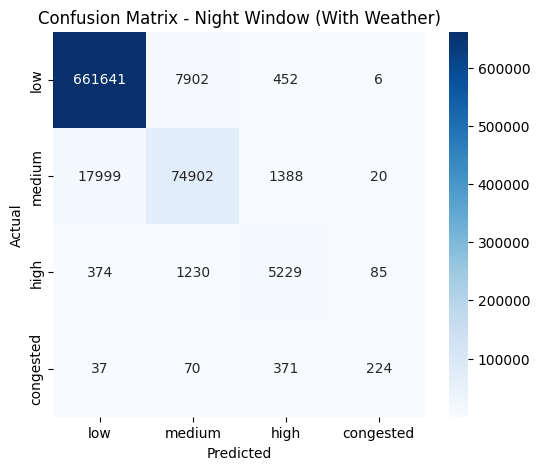

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
traffic_data = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\trafficData.csv")
traffic_stations = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\trafficStations.csv")
weather_data = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\weatherData.csv")

# Prepare date columns
traffic_data['date'] = pd.to_datetime(traffic_data[['year','month','day']])
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Round station lat/lon to match weather data precision
traffic_stations['lat_rounded'] = traffic_stations['wgs84_latitude'].round(2)
traffic_stations['lon_rounded'] = traffic_stations['wgs84_longitude'].round(2)

# Merge lat/lon into traffic data
traffic_data = traffic_data.merge(
    traffic_stations[['station_key', 'lat_rounded', 'lon_rounded']],
    on='station_key', how='left')

# Filter weather data for relevant locations/dates present in traffic_data
unique_locations = traffic_data[['lat_rounded', 'lon_rounded']].drop_duplicates()
unique_dates = traffic_data['date'].drop_duplicates()

weather_filtered = weather_data.merge(unique_locations, on=['lat_rounded', 'lon_rounded'], how='inner')
weather_filtered = weather_filtered[weather_filtered['date'].isin(unique_dates)]

# Merge weather data into traffic_data
traffic_data = traffic_data.merge(
    weather_filtered,
    on=['lat_rounded', 'lon_rounded', 'date'],
    how='left')

# Fill missing weather data
for col in ['daily_rain', 'max_temp', 'min_temp']:
    traffic_data[col].fillna(0, inplace=True)

# Define time windows
time_windows = {
    'morning': [f'hour_{i:02d}' for i in range(6, 10)],
    'noon': [f'hour_{i:02d}' for i in range(10, 16)],
    'afternoon': [f'hour_{i:02d}' for i in range(16, 20)],
    'night': [f'hour_{i:02d}' for i in list(range(20,24)) + list(range(0,6))]
}

# Traffic classification function
def categorize_traffic(count):
    if count <= 1000:
        return 'low'
    elif count <= 2400:
        return 'medium'
    elif count <= 3600:
        return 'high'
    else:
        return 'congested'

# Base features and weather features
features_base = ['station_key', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total']
weather_features = ['daily_rain', 'max_temp', 'min_temp']
categorical_features = ['station_key', 'public_holiday', 'school_holiday']
numeric_features = ['year', 'month', 'day', 'day_of_week', 'daily_total'] + weather_features

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

results = {}

for window_name, hours in time_windows.items():
    print(f"\nTraining model with weather for {window_name} window...")

    # Aggregate features for the window
    traffic_data[f'{window_name}_total'] = traffic_data[hours].sum(axis=1)
    traffic_data[f'{window_name}_max'] = traffic_data[hours].max(axis=1)
    traffic_data[f'{window_name}_mean'] = traffic_data[hours].mean(axis=1)

    # Define target variable for this window based on max traffic
    traffic_data['target'] = traffic_data[f'{window_name}_max'].apply(categorize_traffic)

    # Define features including weather
    features = features_base + [f'{window_name}_total', f'{window_name}_max', f'{window_name}_mean'] + weather_features

    # Convert categorical columns to string type for encoding
    traffic_data['public_holiday'] = traffic_data['public_holiday'].astype(int).astype(str)
    traffic_data['school_holiday'] = traffic_data['school_holiday'].astype(int).astype(str)
    traffic_data['station_key'] = traffic_data['station_key'].astype(str)

    X = traffic_data[features]
    y = traffic_data['target']

    # Train-test split stratified by target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Create and train pipeline
    mlp_clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
    ])

    mlp_clf.fit(X_train, y_train)
    y_pred = mlp_clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{window_name} Accuracy with weather: {acc:.4f}")

    all_classes = ['low', 'medium', 'high', 'congested']
    present_classes = [cls for cls in all_classes if cls in y_test.unique()]

    print(classification_report(y_test, y_pred, labels=present_classes, target_names=present_classes))

    cm = confusion_matrix(y_test, y_pred, labels=present_classes)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=present_classes,
                yticklabels=present_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {window_name.capitalize()} Window (With Weather)')
    plt.show()

    results[window_name] = {
        'model': mlp_clf,
        'accuracy': acc,
        'y_test': y_test,
        'y_pred': y_pred
    }


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
traffic_data = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\trafficData.csv")
traffic_stations = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\trafficStations (1).csv")
weather_data = pd.read_csv(r"C:\Users\Quang Nguyen\OneDrive\Documents\ENGG2112\weatherData.csv")

# Sample 50k rows
traffic_sample = traffic_data.sample(n=50000, random_state=42).copy()

# Prepare date columns
traffic_sample['date'] = pd.to_datetime(traffic_sample[['year','month','day']])
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Round lat/lon for station matching
traffic_stations['lat_rounded'] = traffic_stations['wgs84_latitude'].round(2)
traffic_stations['lon_rounded'] = traffic_stations['wgs84_longitude'].round(2)

# Merge station lat/lon into traffic sample
traffic_sample = traffic_sample.merge(
    traffic_stations[['station_key', 'lat_rounded', 'lon_rounded']],
    on='station_key', how='left')

# Filter weather data for relevant locations and dates
unique_locations = traffic_sample[['lat_rounded', 'lon_rounded']].drop_duplicates()
unique_dates = traffic_sample['date'].drop_duplicates()

weather_filtered = weather_data.merge(unique_locations, on=['lat_rounded', 'lon_rounded'], how='inner')
weather_filtered = weather_filtered[weather_filtered['date'].isin(unique_dates)]

# Merge weather into traffic sample
traffic_sample = traffic_sample.merge(
    weather_filtered,
    on=['lat_rounded', 'lon_rounded', 'date'],
    how='left')

# Fill missing weather values
for col in ['daily_rain', 'max_temp', 'min_temp']:
    traffic_sample[col].fillna(0, inplace=True)

# Define 4-class traffic levels
def categorize_traffic(count):
    if count <= 1000:
        return 'low'
    elif count <= 2400:
        return 'medium'
    elif count <= 3600:
        return 'high'
    else:
        return 'congested'

# Define time windows
time_windows = {
    'morning': [f'hour_{i:02d}' for i in range(6, 10)],
    'noon': [f'hour_{i:02d}' for i in range(10, 16)],
    'afternoon': [f'hour_{i:02d}' for i in range(16, 20)],
    'night': [f'hour_{i:02d}' for i in list(range(20, 24)) + list(range(0, 6))]
}

# Base and weather features
features_base = ['station_key', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total']
weather_features = ['daily_rain', 'max_temp', 'min_temp']
categorical_features = ['station_key', 'public_holiday', 'school_holiday']
numeric_features = ['year', 'month', 'day', 'day_of_week', 'daily_total'] + weather_features

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

results = {}

for window_name, hours in time_windows.items():
    print(f"\nTraining MLP model with weather for {window_name} window...")

    # Aggregate window traffic
    traffic_sample[f'{window_name}_total'] = traffic_sample[hours].sum(axis=1)
    traffic_sample[f'{window_name}_max'] = traffic_sample[hours].max(axis=1)
    traffic_sample[f'{window_name}_mean'] = traffic_sample[hours].mean(axis=1)

    # Define target
    traffic_sample['target'] = traffic_sample[f'{window_name}_max'].apply(categorize_traffic)

    # Features for this window
    features = features_base + [f'{window_name}_total', f'{window_name}_max', f'{window_name}_mean'] + weather_features

    # Convert categorical types
    traffic_sample['public_holiday'] = traffic_sample['public_holiday'].astype(int).astype(str)
    traffic_sample['school_holiday'] = traffic_sample['school_holiday'].astype(int).astype(str)
    traffic_sample['station_key'] = traffic_sample['station_key'].astype(str)

    X = traffic_sample[features]
    y = traffic_sample['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # MLP pipeline
    mlp_clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
    ])

    mlp_clf.fit(X_train, y_train)
    y_pred = mlp_clf.predict(X_test)

    # Overall accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"{window_name} Overall Accuracy: {acc:.4f}")

    # Compute detailed report
    all_classes = ['low', 'medium', 'high', 'congested']
    present_classes = [cls for cls in all_classes if cls in y_test.unique()]
    report_dict = classification_report(
        y_test, y_pred, labels=present_classes, target_names=present_classes, output_dict=True
    )

    # Convert to DataFrame
    report_df = pd.DataFrame(report_dict).transpose().loc[present_classes]

    # Compute per-class accuracy from confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=present_classes)
    per_class_acc = [(cm[i][i] / cm[i].sum()) if cm[i].sum() > 0 else 0 for i in range(len(present_classes))]

    # Insert accuracy as first column
    report_df.insert(0, 'accuracy', per_class_acc)

    # Display enhanced classification report
    print("\nClassification Report with Per-Class Accuracy:")
    print(report_df[['accuracy', 'precision', 'recall', 'f1-score', 'support']].round(4))

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=present_classes,
                yticklabels=present_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {window_name.capitalize()} Window (MLP, 4 Classes)')
    plt.show()

    results[window_name] = {
        'model': mlp_clf,
        'accuracy': acc,
        'y_test': y_test,
        'y_pred': y_pred,
        'report': report_df
    }
